In [1]:
import urllib.request
urllib.request.urlretrieve('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv', 'course_lead_scoring.csv')

('course_lead_scoring.csv', <http.client.HTTPMessage at 0x1d08a6ddd50>)

In [47]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import KFold

In [2]:
df = pd.read_csv('course_lead_scoring.csv')
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [3]:
df.isna().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [4]:
num_cols = df.select_dtypes(include=['number']).columns.difference(['converted'])
cat_cols = df.select_dtypes(include=['object']).columns

In [7]:
for col in num_cols:
    df[col] = df[col].fillna(0)

for col in cat_cols:
    df[col] = df[col].fillna('NA')

In [10]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['converted'].values
y_val = df_val['converted'].values
y_test = df_test['converted'].values

del df_train['converted']
del df_val['converted']
del df_test['converted']

## Q1

In [12]:
feature_auc_scores = {}

for col in num_cols:
    score = df_train[col]
    auc = roc_auc_score(y_train, score)

    if auc < 0.5:
        inverted_score = -df_train[col]
        auc = roc_auc_score(y_train, inverted_score)

    feature_auc_scores[col] = auc

auc_series = pd.Series(feature_auc_scores)

ranked_cols = auc_series.sort_values(ascending=False)

print(ranked_cols)

number_of_courses_viewed    0.763568
interaction_count           0.738270
lead_score                  0.614499
annual_income               0.551958
dtype: float64


`number_of_courses_viewed` has the highest AUC

## Q2

In [19]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[list(cat_cols) + list(num_cols)].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [20]:
def predict(df, dv, model):
    dicts = df[list(cat_cols) + list(num_cols)].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [23]:
dv, model = train(df_train, y_train)

In [34]:
y_pred_proba = predict(df_val, dv, model)

In [29]:
print(roc_auc_score(y_val, y_pred_proba))

0.8171316268814112


## Q3

In [35]:
thresholds = np.linspace(0, 1, 101)

precision_scores = []
recall_scores = []

for t in thresholds:
    y_pred = (y_pred_proba >= t).astype(int)

    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)

    precision_scores.append(precision)
    recall_scores.append(recall)

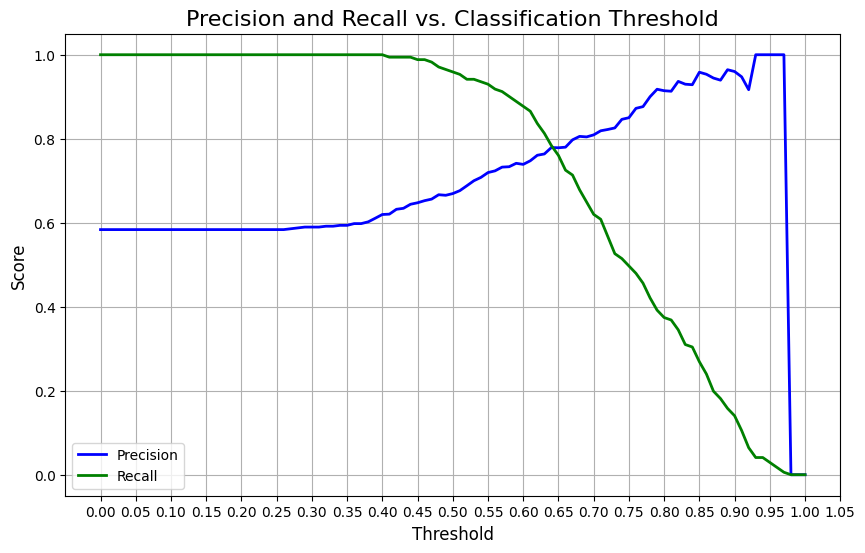

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_scores, label='Precision', color='blue', lw=2)
plt.plot(thresholds, recall_scores, label='Recall', color='green', lw=2)

plt.title('Precision and Recall vs. Classification Threshold', fontsize=16)
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.grid(True)
plt.legend(loc='lower left')
plt.ylim([-0.05, 1.05]) 
plt.xticks(np.arange(0, 1.1, 0.05)) 

plt.show()

## Q4

In [44]:
thresholds = np.linspace(0, 1, 101)

f1_scores = []

for t in thresholds:
    y_pred = (y_pred_proba >= t).astype(int)

    score = f1_score(y_val, y_pred)

    f1_scores.append(score)

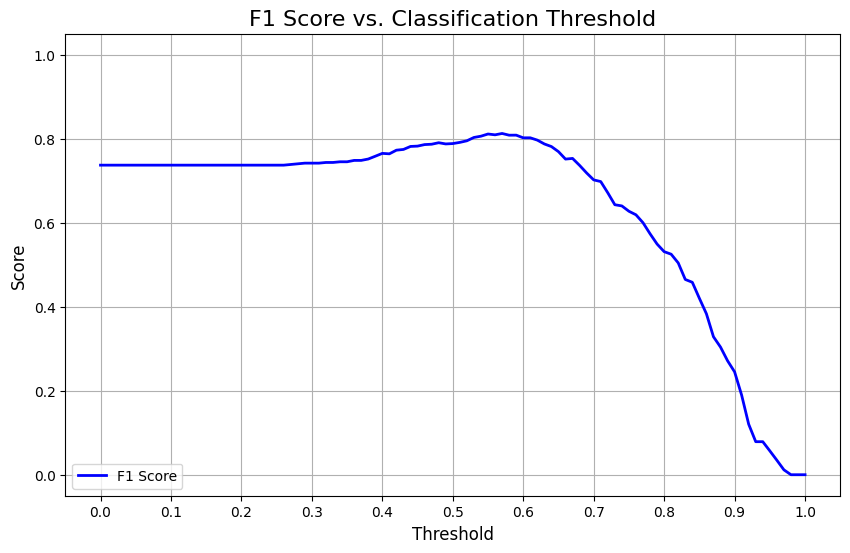

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score', color='blue', lw=2)
plt.title('F1 Score vs. Classification Threshold', fontsize=16)
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.grid(True)
plt.legend(loc='lower left')
plt.ylim([-0.05, 1.05]) 
plt.xticks(np.arange(0, 1.1, 0.1)) 

plt.show()

## Q5

In [48]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train['converted'].values
    y_val = df_val['converted'].values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

In [49]:
np.std(scores)

np.float64(0.03580711942905165)

# Q6

In [66]:
C_values = [0.000001, 0.001, 1.0]

print("--- Manual Cross-Validation Results ---")

for c in C_values:
    # Initialize KFold
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    
    # This list will store the scores for each of the 5 folds
    scores = []

    # Loop through the folds
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train['converted'].values
        y_val = df_val['converted'].values

        # Train the model and get predictions
        dv, model = train(df_train.drop('converted', axis=1), y_train, C=c)
        y_pred = predict(df_val.drop('converted', axis=1), dv, model)

        # Calculate AUC and append to our list
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    # Compute the mean and std after all folds are done
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    
    print(f'C={c}: mean_auc = {mean_score:.3f}, std = {std_score:.3f}')

--- Manual Cross-Validation Results ---
C=1e-06: mean_auc = 0.822, std = 0.036
C=0.001: mean_auc = 0.822, std = 0.036
C=1.0: mean_auc = 0.822, std = 0.036
